## Решение уравнения переноса 

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = f(t, x)$$

$$c > 0$$

Его частное решение имеет вид:

$$u_0(t, x) = \int\limits^t_0 f(s, x - c(t-s)) ds$$

Действительно:

$\frac{\partial u_0}{\partial t} = f(t,x) - c\int\limits^t_0 f_x(s, x - c(t-s)) ds$

$\frac{\partial u_0}{\partial x} = \int\limits^t_0 f_x(s, x - c(t-s)) ds$

Общее решение:

$$u(t, x) = g(x - ct) + \int\limits^t_0 f(s, x - c(t-s)) ds, \;\; g(q) \in C^1(\mathbb{R})$$

Рассмотрим теперь граничное условие, считая, что $f\Big|_{x<0} = 0$:

$u \Big|_{x=0} = \Psi(t) = g(-ct) + \int\limits^t_0 f(s, c(s-t)) ds = g(-ct)$, т.к. $s < t$

Из начальных условий:

$u \Big|_{t=0} = \varphi(x) = g(x)$

Аналитическое решение заданного уравнения:

$$ \boxed{u = \int\limits^t_0 f(s, x - c(t-s)) ds + \begin{cases} \Psi(t - \frac{x}{c}), x < ct \\ \varphi(x-ct), x \ge ct \end{cases}}$$

Будем решать уравнение в области $\{0 < x < L\} \times \{0 < t < T\}$

$L = 20, \;\; T = 10, \;\; c = 2$

$\Phi(x) = \sin(x/2)$

$\Psi(t) = \sin(t)$

Теперь выберем $f(t, x) = \begin{cases} 1, x \in (\alpha_1,\alpha_2) \\ 0, \text{otherwise} \end{cases}$, где $0 < \alpha_1 < \alpha_2 < L$

$\alpha_1 < x - c(t - s) < \alpha_2 \Rightarrow \frac{\alpha_1 - x + ct}{c} = s_{\text{min}} < s < s_{\text{max}} = \frac{\alpha_2 - x + ct}{c}$

$\int\limits^t_0 f(s, x - c(t-s)) ds = \max\{0, \int\limits^{\min\{t, s_{\text{max}}\}}_{\max\{0, s_{\text{min}}\}} ds \} = \frac{1}{c}\max\{0, \min\{x, \alpha_2\} - \max\{x - ct, \alpha_1\} \}$

Окончательно выберем $\alpha_1 = 5, \;\; \alpha_2 = 10$

Теперь, когда мы значем точное решение уравнения, получим численные решения с помощью разностных схем и оценим их точность.

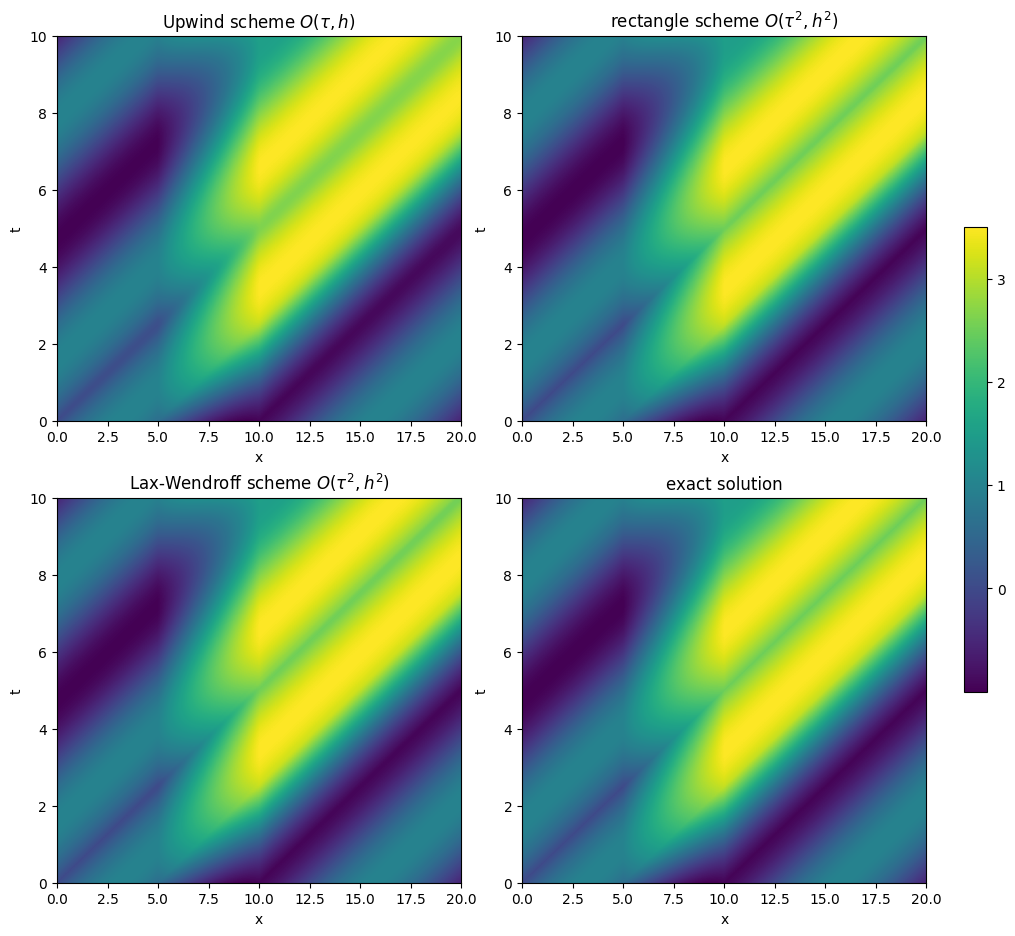

In [15]:
import matplotlib.pyplot as plt
from math import *


from typing import Callable
from dataclasses import dataclass
RtoR = Callable[[float], float]
R2toR = Callable[[float, float], float]

@dataclass
class Grid:
    # time
    T : float
    N : int
    # spatial
    L : float
    M : int

def __prepare(grid : Grid, phi : RtoR, psi : RtoR):
    tau = grid.T / grid.N
    h = grid.L / grid.M
    u = [[phi(m*h) for m in range(grid.M + 1)]]
    for n in range(1, grid.N + 1):
        u += [[psi(tau*n)] + [0 for _ in range(grid.M)]]
    return tau, h, u

# solve u't + c*u'x = f(t, x)
# WARNING: c > 0
# u(0, x) = phi(x)
# u(t, 0) = psi(t)
def solve_by_upwind_scheme(c : float, grid : Grid, phi : RtoR, psi : RtoR, f : R2toR):
    tau, h, u = __prepare(grid, phi, psi)
    cn = c * tau / h # Courant number
    for n in range(grid.N):
        for m in range(1, grid.M + 1):
            u[n+1][m] = u[n][m] - cn*(u[n][m] - u[n][m-1]) + tau*f(tau * n, h * m)
    return u

def solve_by_rectangle_scheme(c : float, grid : Grid, phi : RtoR, psi : RtoR, f : R2toR):
    tau, h, u = __prepare(grid, phi, psi)
    cn = c * tau / h # Courant number
    ct = 1 / (1 + cn)
    ch = cn * ct
    cf = 2 * tau / (1 + cn)
    for n in range(grid.N):
        for m in range(1, grid.M + 1):
            f_nm = f(tau * (n + 0.5), h * (m - 0.5))
            u[n+1][m] = ct*(u[n][m] + u[n][m-1] - u[n+1][m-1]) - ch*(u[n][m] - u[n][m-1] - u[n+1][m-1]) + cf*f_nm
    return u

def solve_by_Lax_Wendroff_scheme(c: float, grid: Grid, phi: RtoR, psi: RtoR, f: R2toR):
    tau, h, u = __prepare(grid, phi, psi)
    cn = c * tau / h  # Courant number
    c1 = cn / 2
    c2 = cn*cn / 2
    for n in range(grid.N):
        for m in range(1, grid.M):
            u[n+1][m] = u[n][m] - c1*(u[n][m+1] - u[n][m-1]) + c2*(u[n][m+1] - 2*u[n][m] + u[n][m-1]) + tau * f(tau * n, h * m)
        u[n+1][grid.M] = u[n+1][grid.M - 1]  # todo
    return u

c = 2
grid = Grid(10, 2000, 20, 1000)

def phi(x : float):
    return sin(x / 2)

def psi(t : float):
    return sin(t)

def f(t : float, x : float):
    if (x < 5) or (x > 10):
        return 0
    return 1

def show_result(u : list[list[float]], grid : Grid, title : str):
    tau = grid.T / grid.N
    h = grid.L / grid.M
    plt.pcolormesh([h*m for m in range(grid.M + 1)], [tau*n for n in range(grid.N + 1)], u)
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title(title)
    plt.colorbar()
    plt.show()

from matplotlib import gridspec
def show_4_results(u_plots: list[tuple[str, list[list[float]]]], grid : Grid):
    tau = grid.T / grid.N
    h = grid.L / grid.M
    x = [h * m for m in range(grid.M + 1)]
    t = [tau * n for n in range(grid.N + 1)]
    fig = plt.figure(figsize=(12, 11))
    gs = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.2)
    axes = []
    plots = []
    for i in range(4):
        ax = fig.add_subplot(gs[i])
        c = ax.pcolormesh(x, t, u_plots[i][1])
        ax.set_title(u_plots[i][0])
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        axes.append(ax)
        plots.append(c)
    fig.colorbar(plots[0], ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
    plt.show()

def u_exact(t : float, x : float):
    i = max(0, min(x, 10) - max(x - c*t, 5))/c
    if x > c*t:
        return i + phi(x - c*t)
    return i + psi(t - x/c)

h = grid.L/grid.M
tau = grid.T / grid.N

def get_error(u : list[list[float]], grid : Grid):
    err2 = 0
    for n in range(grid.N + 1):
        for m in range(grid.M + 1):
            err2 += (u[n][m] - u_exact(n*tau, m*h))**2
    return (err2 / ((grid.N + 1)*(grid.M + 1)))**0.5

show_4_results([
    ("Upwind scheme $O(\\tau, h)$", solve_by_upwind_scheme(c, grid, phi, psi, f)), 
    ("rectangle scheme $O(\\tau^2, h^2)$", solve_by_rectangle_scheme(c, grid, phi, psi, f)),
    ("Lax-Wendroff scheme $O(\\tau^2, h^2)$", solve_by_Lax_Wendroff_scheme(c, grid, phi, psi, f)),
    ("exact solution", [[u_exact(n*tau, m*h) for m in range(grid.M + 1)] for n in  range(grid.N + 1)])
    ], grid)